In [1]:
# TODO: manage imports
library(eurostat)
library(ggplot2)
library(gridExtra)
library(cowplot)
library(repr)
library(vtable)
library(tidyr)
library(tibble)

Loading required package: kableExtra



In [2]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1
data.frame(
  country=c('ČR', 'Norsko', 'Rakousko', 'Belgie', 'Řecko', 'Španělsko', 
            'Nizozemsko', 'Portugalsko', 'Švýcarsko	', 'Finsko', 'Irsko'),
  examiner=c(rep('K. Dedecius', 6), rep('P. Novák', 5))
)[M,]

,country,examiner
,<chr>,<chr>
2,Norsko,K. Dedecius


In [3]:
dataset <- get_eurostat(id='crim_gen_reg')

Table crim_gen_reg cached at /tmp/RtmpjehCSZ/eurostat/d9c5f76c977a6a1c109b30628d9126cd.rds



In [4]:
str(dataset)

tibble [216,947 × 6] (S3: tbl_df/tbl/data.frame)
 $ freq       : chr [1:216947] "A" "A" "A" "A" ...
 $ unit       : chr [1:216947] "NR" "NR" "NR" "NR" ...
 $ iccs       : chr [1:216947] "ICCS0101" "ICCS0101" "ICCS0101" "ICCS0101" ...
 $ geo        : chr [1:216947] "AL" "AL" "AL" "AL" ...
 $ TIME_PERIOD: Date[1:216947], format: "2008-01-01" "2009-01-01" ...
 $ values     : num [1:216947] 88 82 118 124 126 107 98 54 71 52 ...


In [5]:
unique(dataset$TIME_PERIOD)

[1] "2008-01-01" "2009-01-01" "2010-01-01" "2011-01-01" "2012-01-01"
 [6] "2013-01-01" "2014-01-01" "2015-01-01" "2016-01-01" "2017-01-01"
[11] "2018-01-01" "2019-01-01" "2020-01-01" "2021-01-01"

In [6]:
data <- subset(dataset, 
               startsWith(geo, 'NO') &
               nchar(geo) == 5 &
               TIME_PERIOD == '2021-01-01', 
               c(unit, iccs, geo, values))
prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Other theft', 'Vehicle theft')
data$iccs <- factor(data$iccs, levels=prev_labels, labels=new_labels)

In [7]:
data_by_unit <- split(data[, -1], data$unit)
all.equal(data_by_unit$P_HTHAB[, 1:2], data_by_unit$NR[, 1:2])

[1] TRUE

In [8]:
data <- merge(x=data_by_unit$P_HTHAB, y=data_by_unit$NR, by=c('iccs', 'geo'), all=T)  # outer join
colnames(data)[3] <- 'rel'
colnames(data)[4] <- 'abs'

In [9]:
any(is.na(data))

[1] FALSE

In [10]:
freq_df <- pivot_wider(data[, -4], names_from=iccs, values_from=rel)
freq_df[, 'Other theft'] <- freq_df[, 'Other theft'] - freq_df[, 'Vehicle theft']  # TODO: comment above + ref here
freq_table <- (freq_df %>% column_to_rownames('geo') %>% as.matrix() %>% as.table())
names(dimnames(freq_table)) <- c('geo', 'iccs')

In [11]:
freq_df

geo,Int. homicide,Other theft,Robbery,Vehicle theft
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NO020,0.00,788.98,5.13,32.92
NO060,0.21,1320.46,8.91,62.40
NO071,0.00,583.33,1.66,37.03
NO074,0.00,731.72,5.78,43.77
NO081,1.00,2942.85,46.91,74.32
NO082,1.04,1240.03,10.46,54.62
NO091,0.47,1359.86,10.43,91.97
NO092,0.32,1680.79,12.95,112.35
NO0A1,0.00,1389.22,11.40,55.53


In [12]:
# TODO: attention: "data" variable contains incorrect theft values, do not use it below without additional preprocessing

In [13]:
prob_table.row_cond <- prop.table(freq_table, margin=1)
prob_table.col_cond <- prop.table(freq_table, margin=2)

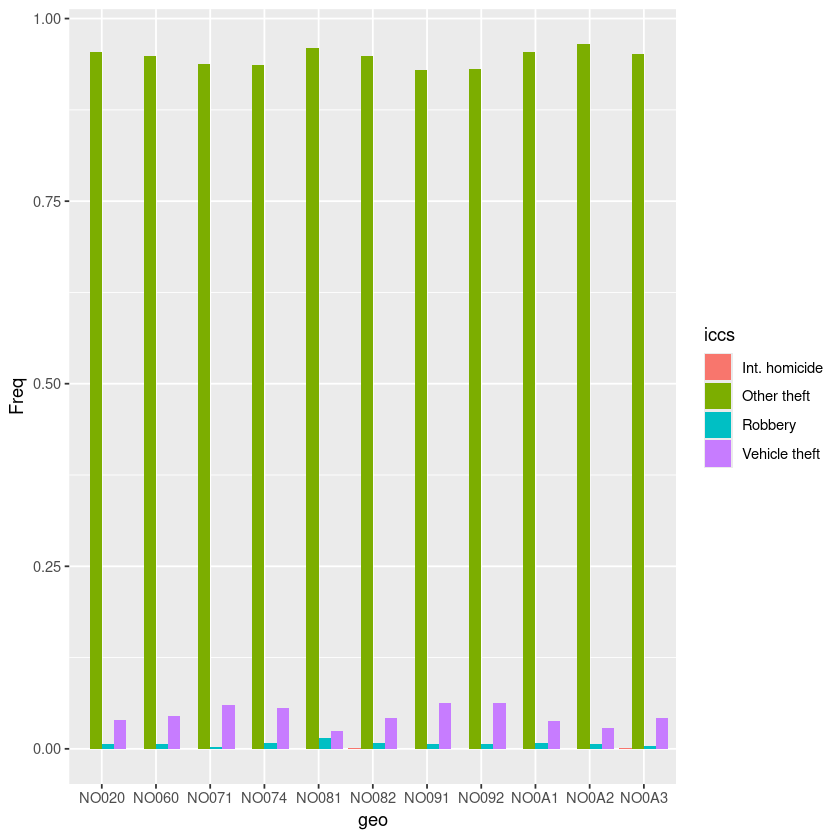

In [14]:
# TODO: rename axes
ggplot(as.data.frame(prob_table.row_cond), aes(x=geo, y=Freq, fill=iccs)) +
    geom_bar(stat='identity', position='dodge')

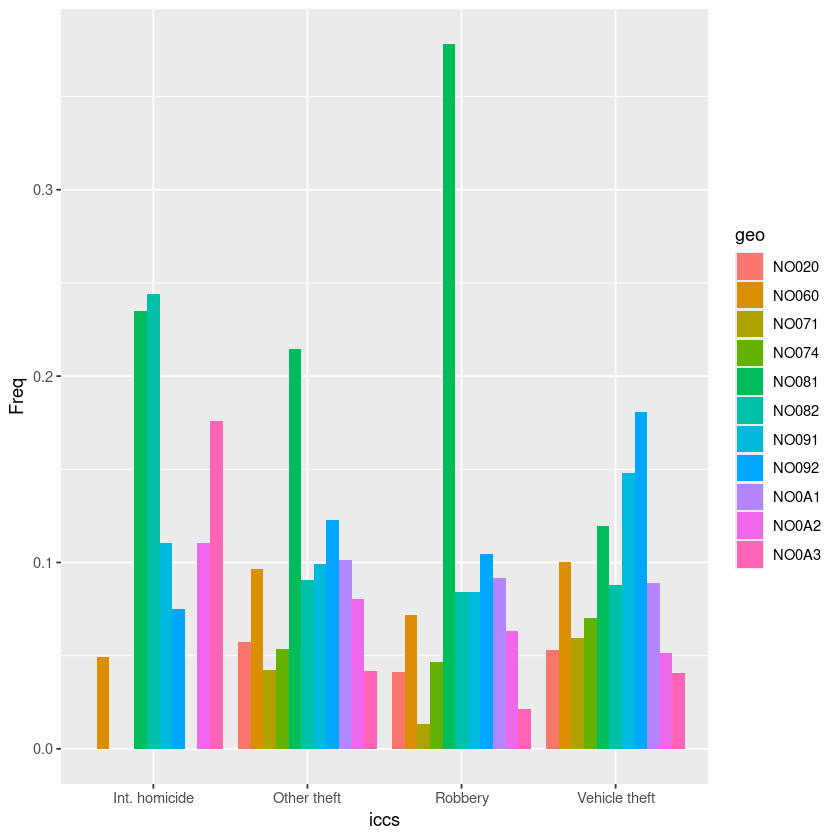

In [15]:
# TODO: rename axes
ggplot(as.data.frame(prob_table.col_cond), aes(x=iccs, y=Freq, fill=geo)) +
    geom_bar(stat='identity', position='dodge')

## Test #2

In [16]:
# TODO: comment everything !!!
# TODO: also mention about mosaic plot ignoring

In [17]:
crime_dynamics <- subset(dataset,
                         geo == 'NO011' & 
                         unit == 'P_HTHAB',
                         c(iccs, TIME_PERIOD, values))
crime_dynamics <- pivot_wider(crime_dynamics, names_from=iccs, values_from=values)
crime_dynamics$ICCS0502 <- crime_dynamics$ICCS0502 - crime_dynamics$ICCS050211

In [18]:
all(colnames(crime_dynamics)[-1] == prev_labels)
colnames(crime_dynamics)[-1] <- new_labels

[1] TRUE

In [19]:
crime_dynamics

TIME_PERIOD,Int. homicide,Robbery,Other theft,Vehicle theft
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2008-01-01,2.14,165.57,7052.66,447.11
2009-01-01,1.22,182.11,7269.82,439.12
2010-01-01,0.85,163.24,6944.59,368.23
2011-01-01,3.17,155.53,7286.86,328.25
2012-01-01,1.30,137.29,7826.21,234.15
2013-01-01,1.28,154.01,6452.44,200.97
2014-01-01,1.10,82.61,5076.51,172.48
2015-01-01,1.85,67.45,4350.07,138.14
2016-01-01,0.61,55.36,3827.81,115.44


Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(new_labels)

  # Now:
  data %>% select(all_of(new_labels))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


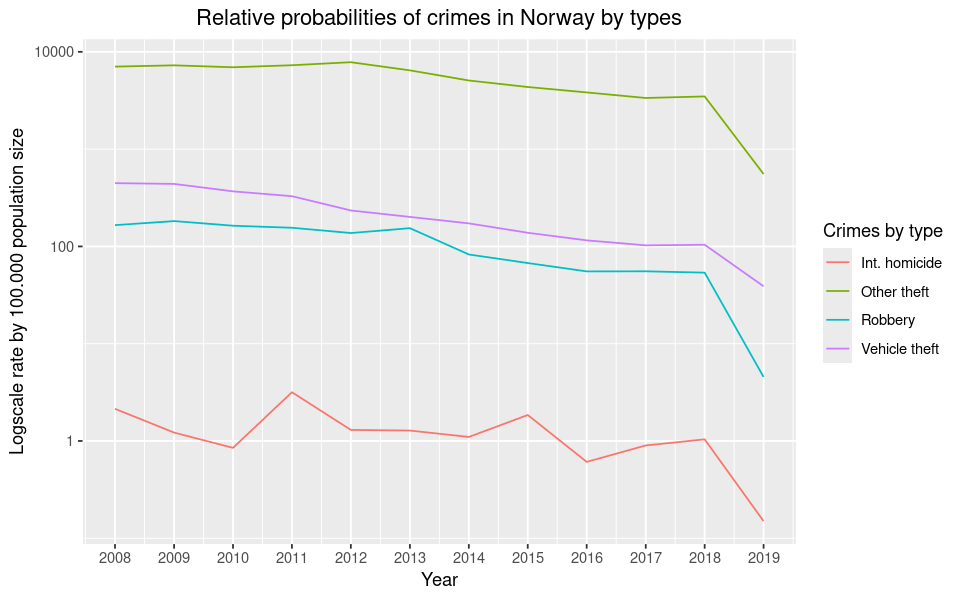

In [20]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(crime_dynamics %>% pivot_longer(cols=new_labels,
                                       names_to='crime',
                                       values_to='values'),
       aes(x=TIME_PERIOD, y=values, color=crime)) +
    geom_line() +
    scale_x_date(breaks=crime_dynamics$TIME_PERIOD, date_labels='%Y') +
    scale_y_continuous(trans='log10') +
    labs(title='Relative probabilities of crimes in Norway by types',
         x='Year',
         y='Logscale rate by 100.000 population size',
         color='Crimes by type') +
    theme(plot.title=element_text(hjust=0.5))

In [21]:
freq_time_vs_crime_df <- subset(crime_dynamics, TIME_PERIOD %in% c('2008-01-01', '2019-01-01'))
freq_time_vs_crime_table <- (freq_time_vs_crime_df %>% column_to_rownames('TIME_PERIOD') %>% as.matrix() %>% as.table())
names(dimnames(freq_time_vs_crime_table)) <- c('year', 'crime')
freq_time_vs_crime_df

TIME_PERIOD,Int. homicide,Robbery,Other theft,Vehicle theft
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2008-01-01,2.14,165.57,7052.66,447.11
2019-01-01,0.15,4.55,554.72,38.91


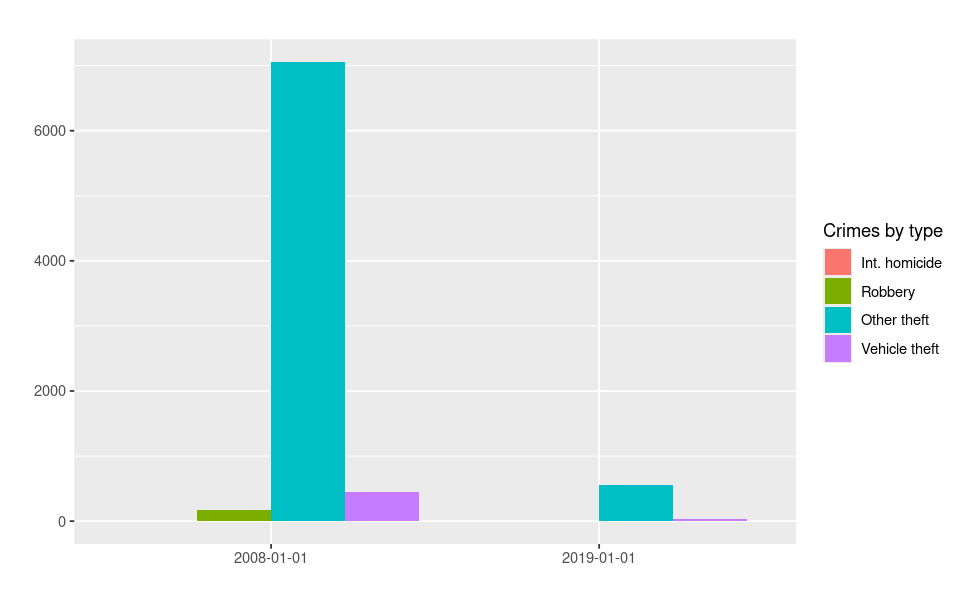

In [22]:
ggplot(as.data.frame(freq_time_vs_crime_table), aes(x=year, y=Freq, fill=crime)) +
    geom_bar(stat='identity', position='dodge') +
    labs(title='', x='', y='',
         fill='Crimes by type') +
    theme(plot.title = element_text(hjust=0.5))
#    scale_y_continuous(trans='log10')  TODO: label bars strict values

In [23]:
fisher.test(freq_time_vs_crime_table * 100, alternative='only used in 2x2 case', simulate.p.value=T)


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  freq_time_vs_crime_table * 100
p-value = 0.0004998
alternative hypothesis: only used in 2x2 case
